# Случайность в вероятности и на практике

О подходах к понятию случайности: 

Н.К. Верещагин, В.А. Успенский, А. Шень. Колмогоровская сложность и алгоритмическая случайность. 
https://www.mccme.ru/free-books/shen/kolmbook.pdf

А.Н. Ширяев. Случайность в вероятности (доклад на семинаре кафедры теории веротяностей). http://www.mathnet.ru:8080/PresentFiles/21897/bsk_2018_10_17_shiryaev_an_randomness_in_probability_slides.pdf

## Генераторы случайных чисел

Что происходит при вызове, напрмер, ```np.random.rand()```?

Как устроен источник случайной последовательности?

![img](https://cdn.ablebits.com/_img-blog/random-generator/random-generator.png)

Рассмотрим простой и популрный алгоритм - Linear congruential generator (LCG). При вызове функции ```rand()``` в C/C++ происзодит обращение именно к LCG.

Linear congruential generator производит последовательность:
$$ z_{i+1} = (az_i + c) \mod m $$

Число $z_0$ называется *seed* и обеспечивает воспроизводимость последовательности “случайных” чисел.

Напишем функцию, которая реализует LCG:

In [ ]:
def rng(m=2**32, a=1103515245, c=12345):
    rng.current = (a * rng.current + c) % m
    return rng.current / m

# setting the seed
rng.current = 1

Выведем несколько первых элементов последовательности:

In [ ]:
[rng() for i in range(10)]

[0.25693503906950355,
 0.5878706516232342,
 0.15432575810700655,
 0.767266943352297,
 0.9738139626570046,
 0.5858681506942958,
 0.8511155843734741,
 0.6132153405342251,
 0.7473867232911289,
 0.06236015981994569]

Выбор параметров $m$, $a$ и $c$ существенно влияет на качество последовательности. Если параметры выбрать наобум, это может привести к неожиданным последствиям:

In [ ]:
def rng(m=97, a=5, c=0):
    rng.current = (a * rng.current + c) % m
    return rng.current / m
rng.current = 7

random = [rng() for i in range(1000)]
print("This sequence looks as random:")
random[:10]

This sequence looks as random:


[0.36082474226804123,
 0.8041237113402062,
 0.020618556701030927,
 0.10309278350515463,
 0.5154639175257731,
 0.5773195876288659,
 0.8865979381443299,
 0.4329896907216495,
 0.16494845360824742,
 0.8247422680412371]

Гистограмма распределения похожа на равномерное:

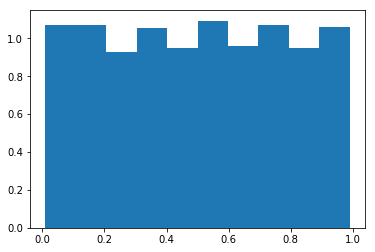

In [ ]:
import matplotlib.pyplot as plt
plt.hist(random, normed=True)
plt.show()

Однако, спектральный тест показывает, что точки располагаются на гиперплоскостях, что плохо согласуется с предствалением о случайности:

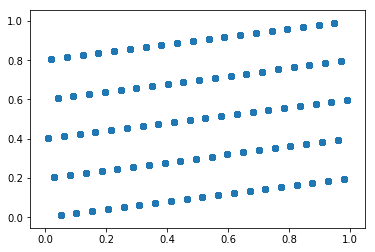

In [ ]:
plt.scatter(random[1:], random[:-1])
plt.show()

Более аккуратный выбор параметров приводит с более "случайному" распределению:

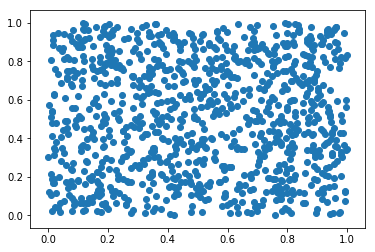

In [ ]:
def rng(m=2**32, a=1103515245, c=12345):
    rng.current = (a * rng.current + c) % m
    return rng.current / m
rng.current = 1

random = [rng() for i in range(1000)]
plt.scatter(random[1:], random[:-1])
plt.show()

Существует набор тестов для проверки "случайности". Например, тесты [Diehard tests](https://en.wikipedia.org/wiki/Diehard_tests).

Больше методов генерации собрано [здесь](https://en.wikipedia.org/wiki/List_of_random_number_generators).

Сюжет про динамические системы и переход к хаосу https://www.youtube.com/watch?v=ovJcsL7vyrk&feature=youtu.be

## Генерация выборки из заданного распределения

Допустим, у нас есть генератор случайных числе из отрезка [0, 1]. Как получить выборку из нового распределения $F$?



### Задача
Смоделировать выборку объема 1000 из дискретного распределения на множестве цифр 0, 1, 2, ..., 9 с весами 0.12, 0.3, 0.167, 0.24, 0.31, 0.54, 0.111, 0.02, 0.001, 0.2. По выборке построить гистограмму. Оптимизируйте алгоритм, упорядочив веса. Сравните время генерации выборки с неупорядоченными и упорядоченными весами.


--- 0.005965471267700195 seconds without order ---


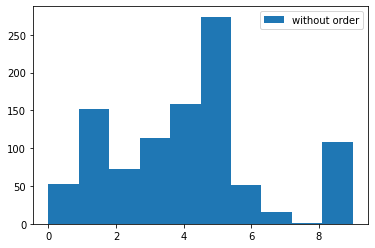

--- 0.004369020462036133 seconds with order ---


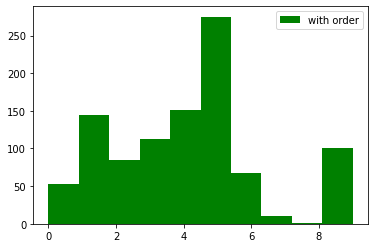

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
def point(b=np.array([-1,0.12, 0.42, 0.587, 0.827,1.137,1.677,1.788,1.808,1.809,2.1])):
    c=np.random.rand()*2.009 #сумма всех весов
    for i in range (10): 
        if(b[i]< c <= b[i+1]):
          return i
def point_order(a = np.array([5,4,1,3,9,2,0,6,7,8]),b=np.array([-1,0.54,0.85,1.15,1.39,1.59,1.757,1.877,1.988,2.008,2.1])):
    c=np.random.rand()*2.009 #сумма всех весов
    for i in range (10): 
        if(b[i]< c <= b[i+1]):
          return a[i]
start_time = time.time()
random1 = [point() for i in range(1000)]
t1 = time.time() - start_time
start_time = time.time()
random2 = [point_order() for i in range(1000)]
t2 = time.time() - start_time
random1[:10]
random2[:10]
print("--- %s seconds without order ---" % (t1))
plt.hist(random1,label="without order")
plt.legend()
plt.show()
print("--- %s seconds with order ---" % (t2))
plt.hist(random2, color = "g", label="with order")
plt.legend()
plt.show()


### Inverse transform method

В следующем предложении заключается идея метода *inverse transform*:

Если $\xi$ имеет равномерное распределение в $[0,1]$, тогда $F^{-1}(\xi)$ распределена по закону $F$. (Для каких $F$ это верно?)

### Задача
Смоделируйте выборку размера 1000 из распределения $Exp(\lambda)$. Постройте выборочную гистограмму и точный график плотности распределения.

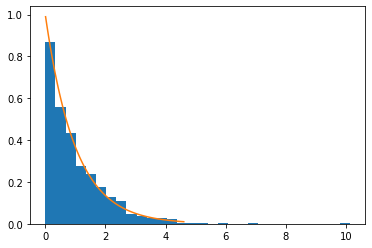

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.stats import expon
def rng(alf=1):
    a = np.random.rand()
    x = ( - math.log(1 - a) / alf)
    return x
alf = 1
x = np.linspace(expon.ppf(0.01), expon.ppf(0.99), 100)
random = [rng(alf) for i in range(1000)]
plt.hist(random, bins = 30, density=True)
plt.plot(x, expon.pdf(x))
plt.show()

### Rejection sampling (Accept-reject method)

Идея метода: сэмплить из распределения, из которого умеем, а затем отбирать точки, которые следуют нужному распределению. Картинка иллюстрирует идею метода:
<img src=https://colcarroll.github.io/hamiltonian_monte_carlo_talk/images/bayes_talk.015.png style="width: 50%;"/>
 

### Задача
Обоснуйте, что метод accept-reject действительно производит выборку из нужного распределения. Смоделируйте 1000 точек из усеченного распределения Коши, приведенного ниже, используя генератор равномерного распределения. Нарисуйте график полученной выборочной гистограммы и сравните его с графиком точной функции плотности.

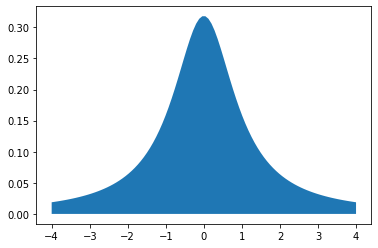

In [ ]:
from scipy import stats
import numpy as np
import seaborn as sns
dist = stats.cauchy()
x = np.linspace(-4, 4, 100)
plt.fill_between(x, 0, dist.pdf(x)) #needs to be normalized!
plt.show()

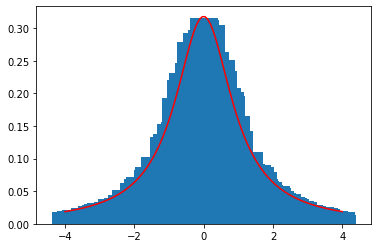

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import stats
import seaborn as sns
def rng():
    a = [0,0]
    a[1] = 1/math.pi*np.random.rand()
    if np.random.rand()>0.5:
      a[0] = 4*np.random.rand()
    else: a[0] = -4*np.random.rand()
    while a[1] > 1/(math.pi*(1+a[0]*a[0])):
       a[1] = 1/math.pi*np.random.rand()
    return a
random = [rng() for i in range(1000)]
randomx = [random[i][0] for i in range(1000)]
randomy = [random[i][1] for i in range(1000)]
plt.bar(randomx, randomy)
dist = stats.cauchy()
x = np.linspace(-4, 4, 100)
plt.plot(x, dist.pdf(x), color='r')
plt.show()

##  Coordinate transformation method

Метод аccept-reject в ряде случаев может оказываться неэффективным и требовать слишком много пробных точек. Альтернатива -  попробовать найти преобразование координат, которое переводит простую область (из которой легко сэмплить, например, едининчный квадрат) в требуемую, но при этом сохраняет соотношение площадей.

### Задача
Смоделировать выборку из 500 точек равномерно распределенных внутри данного треугольника без использования метода отбора. 

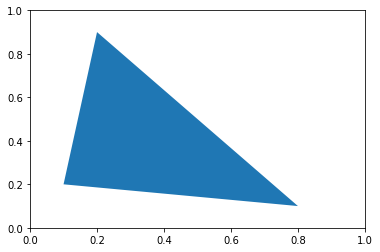

In [ ]:
import matplotlib
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

polygon = Polygon(0.1 * np.array([[1, 2], [2, 9], [8, 1]]), True)
plt.gca().add_collection(PatchCollection([polygon]))
plt.show()

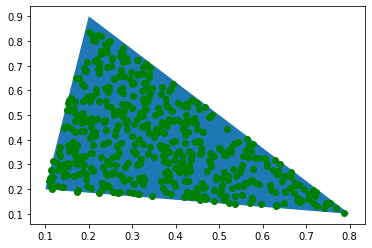

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
def random_tr():
  a = np.array([np.random.rand(),np.random.rand()])
  if(a[0]+a[1]>1):
    d = (a[0] + a[1] - 1) / math.sqrt(2)
    a[0] = a[0] - d * math.sqrt(2)
    a[1] = a[1] - d * math.sqrt(2)
  s = math.sqrt(50)
  a = a * (0.1*s)
  a[0] = a[0] * (7/s) + a[1] * (1/s)
  a[1] = -a[0] * (1/s) + a[1] * (7/s)
  a = a + [0.1,0.2]
  return a
polygon = Polygon(0.1 * np.array([[1, 2], [2, 9], [8, 1]]), True)
plt.gca().add_collection(PatchCollection([polygon]))
random = [random_tr() for i in range(500)]
randomx = [random[i][0] for i in range(500)]
randomy = [random[i][1] for i in range(500)]
plt.scatter(randomx, randomy, c="g")
plt.show()

### Задача
Смоделировать выборку из 500 точек внутри данного круга без использования метода отбора.

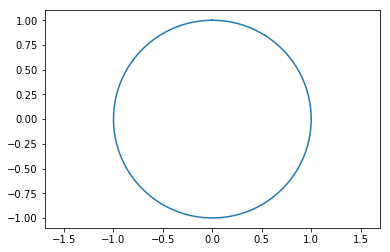

In [ ]:
from matplotlib.patches import Circle
t = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.sin(t), np.cos(t))
plt.axis('equal')
plt.show()

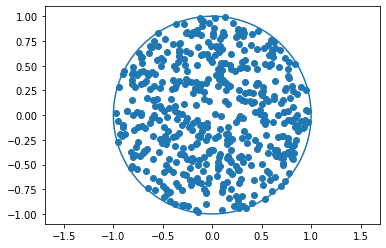

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib.patches import Circle
def random_cr():
  a = np.array([np.random.rand(),np.random.rand()])
  r = a[1]
  fi = a[0]*2*math.pi
  a[0] = r**0.5 * math.cos(fi)
  a[1] = r**0.5 * math.sin(fi)
  return a
random = [random_cr() for i in range(500)]
randomx = [random[i][0] for i in range(500)]
randomy = [random[i][1] for i in range(500)]
t = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.sin(t), np.cos(t))
plt.axis('equal')
plt.scatter(randomx, randomy)

### Задача
Напишите функцию, которая моделирует случайное симметричное блуждание на двумерной решетке длины n c началом и концом в точке (0, 0). Приведите графики выборочных траекторий для n=100.

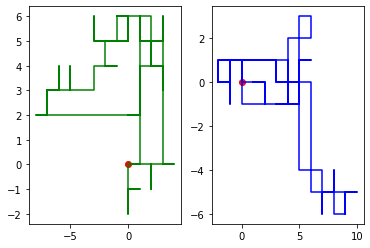

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import math
def random(n):
    x1 = np.random.choice(np.arange(n), n//2, replace = False)
    y1 = np.random.choice(np.arange(n), n//2, replace = False)
    x2 = np.ones(n)
    y2 = np.ones(n)
    x2[-x1] = -1
    y2[-y1] = -1
    x3 = np.cumsum(x2)
    y3 = np.cumsum(y2)
    x = (x3+y3)/2
    y = (x3-y3)/2
    return x,y

X, Y = random(100)
plt.subplot(1,2,1)
plt.plot(X,Y, color='g')
plt.scatter([0], [0], color='r')
X, Y = random(100)
plt.subplot(1,2,2)
plt.plot(X,Y,color='b')
plt.scatter([0], [0], color='r')
plt.show()

## Random normal generator

### Задача
Докажите, что приведенный ниже алгоритм (Box-Muller algorithm) формирует выборку из независимых N(0,1) случаных величин. Модифицируйте метод, чтобы исключить вызовы тригонометрических функций ```np.sin``` и ```np.cos```. С помощью модифицированного метода смоделируйте выборку объема 1000 из двумерного гауссовского распределения со средним (3, 6) и ковариационной матрицей ((2, 1), (1, 4)). Постройте 2D гистограмму полученного распределения.

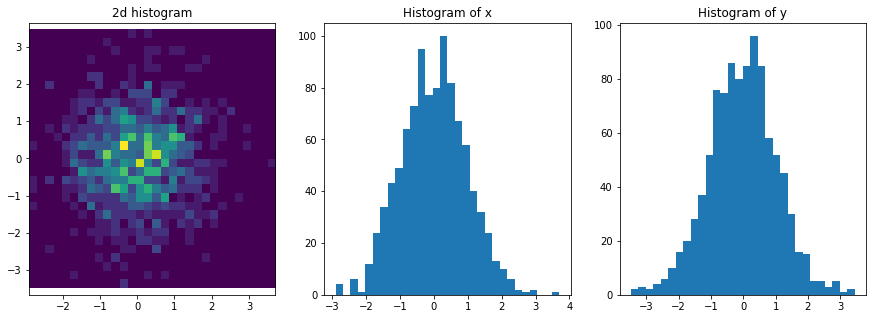

In [ ]:
n = 1000
u1, u2 = np.random.rand(2, n)
r = np.sqrt(-2 * np.log(u1))
theta = 2 * np.pi * u2
x = r * np.cos(theta)
y = r * np.sin(theta)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].hist2d(x, y, bins=30)
ax[0].axis('equal')
ax[1].hist(x, bins=30)
ax[2].hist(y, bins=30)
ax[0].set_title("2d histogram")
ax[1].set_title("Histogram of x")
ax[2].set_title("Histogram of y")
plt.show()

In [ ]:
# Solution here

### Задача
Перейдите от вектора из независимых стандартных нормальных величин к гауссовскому вектору с нулевым средним и заданной ниже ковариационно матрицей. Обоснуйте теоретически и численно, что полученный вектор обладает требуемой ковариационной матрицей.


In [ ]:
B = np.array([[ 2.,  0.,  0.,  0., -1.,  0.,  0.,  0., -1.],
              [ 0.,  4.,  0., -1.,  0.,  0.,  0.,  0.,  0.],
              [ 0.,  0.,  4.,  0.,  0.,  0., -1.,  0.,  0.],
              [ 0., -1.,  0.,  4.,  0.,  0.,  0.,  0.,  0.],
              [-1.,  0.,  0.,  0.,  2.,  0.,  0.,  0., -1.],
              [ 0.,  0.,  0.,  0.,  0.,  4.,  0., -1.,  0.],
              [ 0.,  0., -1.,  0.,  0.,  0.,  4.,  0.,  0.],
              [ 0.,  0.,  0.,  0.,  0., -1.,  0.,  4.,  0.],
              [-1.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  2.]])

### Задача
С помощью метода Монте-Карло (бросанием случайной точки в квадрат) оцените число $\pi$. Теоретически обоснуйте необходимое число бросаний, чтобы оценить число $\pi$ с точностью 3 знака после запятой и достоверностью 99%. С помощью метода Монте-Карло оцените, сколько на практике требуется бросаний, чтобы достичь с требуемой достоверностью нужной точности.


In [ ]:
# Solution here

### Задача

Реализовать метод генерации случайного разбиения n-элементного множества на подмножества. С его помощью оценить ожидаемое число подмножеств в случайном разбиении множества из 100 элементов. 

Подсказка 1: Ширяев, Вероятность, т1, задача 2 к параграфу 1.

Подсказка 2: http://djalil.chafai.net/blog/2012/05/03/generating-uniform-random-partitions/

In [ ]:
# Solution here